In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Places2

In [ ]:
import shutil 
shutil.unpack_archive("drive/MyDrive/Places2.zip", "Places2/")

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split

import numpy as np

In [ ]:
data_dir = "/content/Places2/Places2"

print(os.listdir(data_dir)) #folders inside dataset directory

classes = os.listdir(data_dir +"/train")
print(classes)

['train', 'test']
['outdoor', 'indoor']


In [ ]:
from torchvision.datasets import ImageFolder

from torchvision import transforms
from torchvision.transforms import ToTensor

train_transformations = transforms.Compose([                                                                                 
    transforms.Resize((256,256)), #resize input images to 255,255
    transforms.ToTensor()
])

test_transformations = transforms.Compose([
    transforms.Resize((256,256)), #resize input images to 255,255
    transforms.ToTensor()
])

#applt the train and test transformations
#training_dataset = ImageFolder(data_dir+'/Training', transform=train_transformations)  
#testing_dataset= ImageFolder(data_dir+'/Testing', transform=test_transformations)
training_dataset = ImageFolder(root='/content/Places2/Places2/train', transform=train_transformations)
testing_dataset = ImageFolder(root='/content/Places2/Places2/test', transform=test_transformations)

In [ ]:
print(training_dataset.classes)

['indoor', 'outdoor']


In [ ]:
#splitting training dataset into train_ds and val_ds 

random_seed = 42
torch.manual_seed(random_seed);

val_size = 1163
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4650, 1163)

Label:  indoor (0)


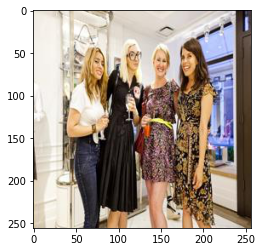

In [ ]:
#viewing the images by matplotlib

import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', training_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #change dimension from 3,255,255 to 255,255,3 for matplotlib 

show_example(*training_dataset[700])    

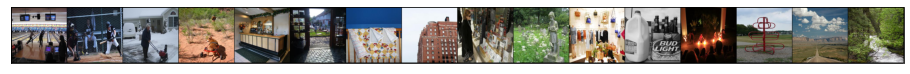

In [ ]:
#We can now create data loaders for training and validation, to load the data in batches

from torch.utils.data.dataloader import DataLoader

batch_size=16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

#We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer): 
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() 
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_dataset.classes[preds[0].item()]

In [ ]:
import torchvision.models as models

class Resnet34CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34

Resnet34CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
evaluate(model_resnet34, val_dl)

{'val_acc': 0.518964946269989, 'val_loss': 0.7826387286186218}

In [ ]:
model_resnet34.freeze()

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:

history6 = fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 0.4761, val_loss: 0.7337, val_acc: 0.5772
Epoch [1], train_loss: 0.5789, val_loss: 0.4841, val_acc: 0.7780
Epoch [2], train_loss: 0.5425, val_loss: 0.5177, val_acc: 0.7350
Epoch [3], train_loss: 0.4914, val_loss: 0.4545, val_acc: 0.8008
Epoch [4], train_loss: 0.4633, val_loss: 0.4321, val_acc: 0.8127
Epoch [5], train_loss: 0.4508, val_loss: 0.4052, val_acc: 0.8236
Epoch [6], train_loss: 0.4138, val_loss: 0.3971, val_acc: 0.8279
Epoch [7], train_loss: 0.3976, val_loss: 0.3759, val_acc: 0.8388


In [ ]:
model_resnet34.unfreeze()

epochs=8
history6 += fit_one_cycle(epochs, 0.001, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 0.3819, val_loss: 0.4080, val_acc: 0.8177
Epoch [1], train_loss: 0.4048, val_loss: 0.4042, val_acc: 0.8388
Epoch [2], train_loss: 0.3954, val_loss: 0.3821, val_acc: 0.8430
Epoch [3], train_loss: 0.3797, val_loss: 0.3862, val_acc: 0.8438
Epoch [4], train_loss: 0.3745, val_loss: 0.3679, val_acc: 0.8406
Epoch [5], train_loss: 0.3572, val_loss: 0.3736, val_acc: 0.8480
Epoch [6], train_loss: 0.3298, val_loss: 0.3561, val_acc: 0.8573
Epoch [7], train_loss: 0.3234, val_loss: 0.3525, val_acc: 0.8598


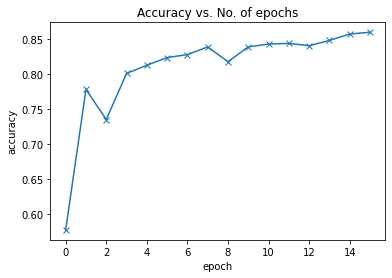

In [ ]:
plot_accuracies(history6)

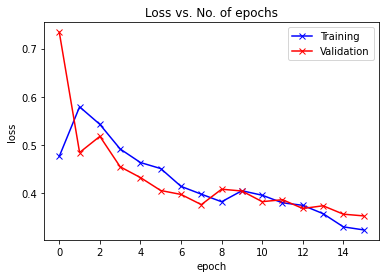

In [ ]:
plot_losses(history6)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

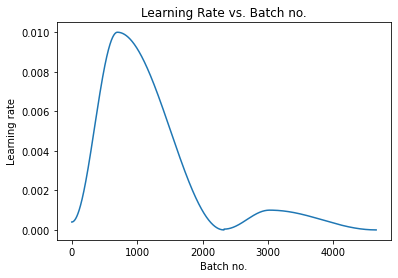

In [ ]:
plot_lrs(history6)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet34, test_loader)
result

{'val_acc': 0.8589867949485779, 'val_loss': 0.3330358564853668}

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/modelplacesusingresnet34.pth" 
torch.save(model_resnet34.state_dict(), path) 

In [ ]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modelplacesusingresnet34.pth"))

<All keys matched successfully>

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet34, test_loader)

{'val_acc': 0.8589867949485779, 'val_loss': 0.3330358564853668}

Label: outdoor , Predicted: outdoor


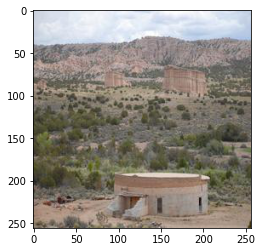

In [ ]:
img, label = testing_dataset[900]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))

Label: indoor , Predicted: indoor


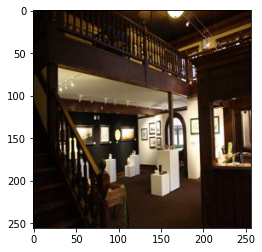

In [ ]:
img, label = testing_dataset[125]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))